In [1]:
import git
from pathlib import Path
import os
import numpy as np
import tqdm
import scipy.ndimage as ndi
import pandas as pd
from skimage.filters import gabor_kernel
from scipy.signal import fftconvolve

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from learned import *

np.random.seed(0)

In [2]:
def _generate_gabor_kernel_skimage_cached(frequency: float,
                                          wave_number: int,
                                          theta: float,
                                          aspect_ratio: float,
                                          dtype_str: str) -> np.ndarray:
    if frequency <= 0:
        raise ValueError("frequency must be positive (cycles/pixel).")
    
    # choose n_stds explicitly (same value you pass to gabor_kernel; default is 3)
    n_stds = 3
    sigma_x = wave_number / (2.0 * n_stds * frequency)   # NOT 4*frequency
    sigma_y = aspect_ratio * sigma_x
    k_complex = gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma_x, sigma_y=sigma_y, n_stds=n_stds)

    k = np.real(k_complex).astype(np.dtype(dtype_str), copy=False)
    k -= k.mean()
    nrm = np.linalg.norm(k.ravel())
    if nrm > 1e-12:
        k = k / nrm
    return k

def generate_gabor_kernel_skimage(frequency: float,
                                  wave_number: int,
                                  theta: float = 0.0,
                                  aspect_ratio: float = 1.0,
                                  dtype=np.float64) -> np.ndarray:
    """Public wrapper returning a copy to avoid accidental mutation of cached data."""
    arr = _generate_gabor_kernel_skimage_cached(
        float(frequency), int(wave_number), float(theta),
        float(aspect_ratio), np.dtype(dtype).name
    )
    if arr is not None:
        return arr.copy()
    return None

In [3]:
param_df = pd.read_csv(os.path.join(ROOT_DIR, "gabor", "gabor_test.csv"))

orientations = [0, np.pi/4, np.pi, 7 * np.pi/4]

filters = []
for i in range(len(param_df)):
    for j in range(len(orientations)):
        fil = generate_gabor_kernel_skimage(param_df["frequency"][i], param_df["wave_number"][i], orientations[j], param_df["aspect_ratio"][i])
        if fil is not None:
            filters.append(fil)

for i in range(20):
    print(i, filters[i].shape)
print(len(filters))

0 (35, 69)
1 (49, 49)
2 (35, 69)
3 (49, 49)
4 (21, 39)
5 (29, 29)
6 (21, 39)
7 (29, 29)
8 (13, 23)
9 (17, 17)
10 (13, 23)
11 (17, 17)
12 (7, 13)
13 (11, 11)
14 (7, 13)
15 (11, 11)
16 (5, 9)
17 (7, 7)
18 (5, 9)
19 (7, 7)
80


In [4]:
# TODO: for quick testing purposes
filters = filters[8:12]

In [5]:
DATASET = "coco"
RAW_DATA_SUFFIX = "outdoor-coco-cropped-normalized"
FINAL_DATA_NAME = 'coco-orient-test' 
CONSTANT_SAMPLE_SIZE = int(1e5)

num_images=500
jitter=False 
normalize=False 

#data_dir = os.path.join(ROOT_DIR, 'raw-data', DATASET, RAW_DATA_SUFFIX)
data_dir = os.path.join(ROOT_DIR, 'raw-data', RAW_DATA_SUFFIX)

In [6]:
images = load_images_from_directory(data_dir, n=num_images, jitter=jitter, normalize=normalize)
print("num_images, H, W, channels:", images.shape, "\nnum_filters", len(filters))

Loading images:   0%|          | 0/500 [00:00<?, ?it/s]

num_images, H, W, channels: (500, 256, 256, 3) 
num_filters 4


In [7]:
def apply_filter(image, filter):
    """
    Applies Gabor filter to the input RGB image.
    """
    # print(image.shape)
    # print(filter.shape)
    out = np.zeros_like(image)
    for ch in range(3):
        out[:, :, ch] = ndi.convolve(
            image[:, :, ch],
            filter,
            mode='reflect'
        )
    return out

In [8]:
filter_data_map = dict()
print(filters[0].shape)

for i in tqdm(range(len(filters))):
    
    fil = filters[i]
    transformed = []
    for j, image in enumerate(images):
        convolved = apply_filter(image, fil)
        transformed.append(convolved.flatten())

    transformed = np.hstack(transformed)
    # select max of CONSTANT_SAMPLE_SIZE coefs
    transformed = np.sort(transformed)[np.round(np.linspace(0, transformed.size - 1, min(transformed.size, CONSTANT_SAMPLE_SIZE))).astype(int)]
    filter_data_map[i] = transformed

filter_data_map[0]

(13, 23)


  0%|          | 0/4 [00:00<?, ?it/s]

array([-25.88777114, -21.13559706, -19.37066567, ...,  23.11613872,
        24.60754763,  28.13199528])

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def _safe_hist_density(x, bins="auto", range=None):
    """Density-normalized histogram (pdf estimate) and bin centers."""
    hist, edges = np.histogram(x, bins=bins, range=range, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    width = np.diff(edges)
    # Ensure true density integrates to 1 even with finite precision
    hist = hist / (np.sum(hist * width) + 1e-12)
    return hist, centers, edges, width

def _kl_divergence(p, q, width):
    """KL(P||Q) for binned densities with smoothing; integrates over bins."""
    eps = 1e-12
    p_ = np.clip(p, eps, None)
    q_ = np.clip(q, eps, None)
    return np.sum(p_ * np.log(p_ / q_) * width)

def _js_divergence(p, q, width):
    """Jensen–Shannon divergence and distance (sqrt(JS))."""
    m = 0.5 * (p + q)
    js = 0.5 * _kl_divergence(p, m, width) + 0.5 * _kl_divergence(q, m, width)
    return js, np.sqrt(js)

def _hellinger_distance(p, q, width):
    """Hellinger distance for binned densities."""
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2 * width))

def compare_and_plot(
    x, y,
    bins="auto",
    value_range=None,      # pass a tuple (lo, hi) to compare on same support
    show_kde=True,         # Gaussian KDE overlay (Scipy)
    show_cdf=True,         # empirical CDF overlay
    title="Distribution comparison",
    figsize=(8, 6),
    alpha=0.35,
    colors=("C0", "C3"),
    labels=("A", "B"),
    ax=None
):
    """
    Plot overlaid histograms (+ optional KDE & CDF) and return precise metrics.
    Metrics include KS, Wasserstein (EMD), CvM, KL (both directions), JS, Hellinger,
    Bhattacharyya coefficient, and area between density curves.
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    # Common range unless user supplies one
    lo = np.nanmin([x.min(), y.min()]) if value_range is None else value_range[0]
    hi = np.nanmax([x.max(), y.max()]) if value_range is None else value_range[1]
    value_range = (lo, hi)

    # Histograms (density)
    p, centers, edges, width = _safe_hist_density(x, bins=bins, range=value_range)
    q, _,     _,     _     = _safe_hist_density(y, bins=edges, range=value_range)  # reuse edges

    # Distances / similarities (binned)
    js, js_dist = _js_divergence(p, q, width)
    kl_pq = _kl_divergence(p, q, width)
    kl_qp = _kl_divergence(q, p, width)
    hell  = _hellinger_distance(p, q, width)
    # Bhattacharyya coefficient and distance
    bc = np.sum(np.sqrt(p * q) * width)
    bhattacharyya = -np.log(bc + 1e-12)

    # Area between density curves (L1)
    l1_area = np.sum(np.abs(p - q) * width)

    # Nonparametric tests / distances (sample-based)
    ks = stats.ks_2samp(x, y, alternative="two-sided", method="auto")
    w1 = stats.wasserstein_distance(x, y)
    try:
        cvm = stats.cramervonmises_2samp(x, y)
    except Exception:
        cvm = None  # older SciPy

    # Set up axes
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        created_fig = True

    # Overlaid histograms
    ax.hist(x, bins=edges, density=True, alpha=alpha, color=colors[0], label=f"{labels[0]} hist")
    ax.hist(y, bins=edges, density=True, alpha=alpha, color=colors[1], label=f"{labels[1]} hist")

    # KDE (optional)
    if show_kde:
        try:
            kde_x = stats.gaussian_kde(x)
            kde_y = stats.gaussian_kde(y)
            grid = np.linspace(lo, hi, 1024)
            ax.plot(grid, kde_x(grid), color=colors[0], lw=2, label=f"{labels[0]} KDE")
            ax.plot(grid, kde_y(grid), color=colors[1], lw=2, label=f"{labels[1]} KDE")
        except Exception:
            pass  # KDE can fail with few/degenerate points

    # CDF (optional): plot on secondary axis for clarity
    if show_cdf:
        ax2 = ax.twinx()
        xs = np.sort(x)
        ys = np.sort(y)
        Fx = np.linspace(0, 1, len(xs), endpoint=True)
        Fy = np.linspace(0, 1, len(ys), endpoint=True)
        ax2.plot(xs, Fx, color=colors[0], lw=1.2, ls="--", alpha=0.9, label=f"{labels[0]} CDF")
        ax2.plot(ys, Fy, color=colors[1], lw=1.2, ls="--", alpha=0.9, label=f"{labels[1]} CDF")
        ax2.set_ylabel("CDF")
        # show KS statistic visually (optional): vertical distance at max diff
        # (skip plotting the marker to keep it clean)

        # Merge legends
        lines1, labs1 = ax.get_legend_handles_labels()
        lines2, labs2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labs1 + labs2, loc="best")
    else:
        ax.legend(loc="best")

    ax.set_title(title)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.2)

    # Metrics textbox
    txt = [
        f"KS D={ks.statistic:.4g} (p={ks.pvalue:.3g})",
        f"Wasserstein W₁={w1:.4g}",
        f"CvM={getattr(cvm, 'statistic', np.nan):.4g}" if cvm is not None else "CvM=NA",
        f"JS={js:.4g}  (JS⁰·⁵={js_dist:.4g})",
        f"KL(P‖Q)={kl_pq:.4g}  KL(Q‖P)={kl_qp:.4g}",
        f"Hellinger={hell:.4g}",
        f"Bhattacharyya={bhattacharyya:.4g}  (BC={bc:.4g})",
        f"L1 area={l1_area:.4g}",
    ]
    ax.text(
        0.99, 0.01, "\n".join(txt),
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=9, family="monospace",
        bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85, lw=0.5)
    )

    if created_fig:
        plt.tight_layout()
        plt.show()

    return {
        "ks_stat": ks.statistic, "ks_p": ks.pvalue,
        "wasserstein": w1,
        "cvm_stat": None if cvm is None else cvm.statistic,
        "js_div": js, "js_dist": js_dist,
        "kl_pq": kl_pq, "kl_qp": kl_qp,
        "hellinger": hell,
        "bhattacharyya": bhattacharyya, "bc": bc,
        "l1_area": l1_area
    }

0 deg -- mean: 1.1690276172739686e-05, var: 4.220124442651982
180 deg -- mean: 1.1690276172757877e-05, var: 4.220124442651983


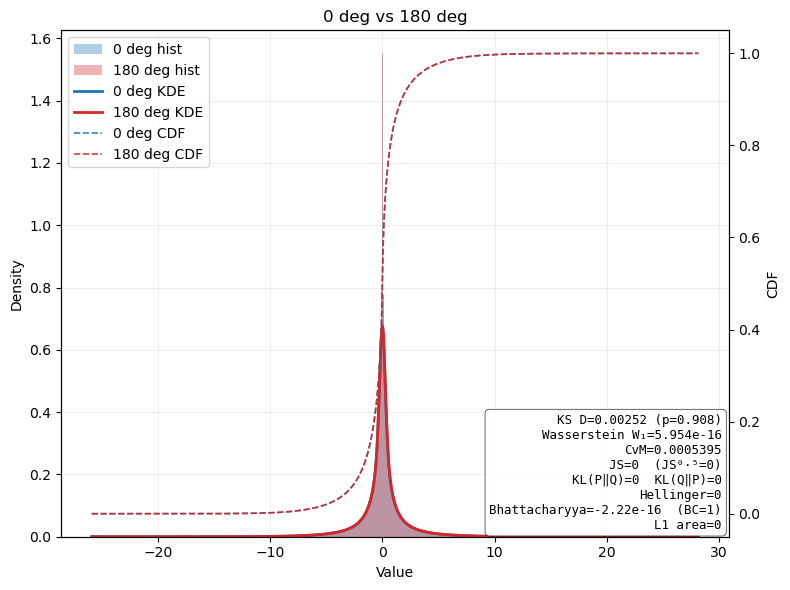

{'ks_stat': 0.0025199999999999667, 'ks_p': 0.9078162310245469, 'wasserstein': 5.954347495354335e-16, 'cvm_stat': 0.0005395155239966698, 'js_div': 0.0, 'js_dist': 0.0, 'kl_pq': 0.0, 'kl_qp': 0.0, 'hellinger': 0.0, 'bhattacharyya': -2.2204460492503128e-16, 'bc': 0.9999999999990001, 'l1_area': 0.0}


In [12]:
# 0 deg. vs. 180 deg.

print(f"0 deg -- mean: {np.mean(filter_data_map[0])}, var: {np.var(filter_data_map[0])}")
print(f"180 deg -- mean: {np.mean(filter_data_map[2])}, var: {np.var(filter_data_map[2])}")

# x and y are 1D numpy arrays of samples
metrics = compare_and_plot(
    filter_data_map[0], filter_data_map[2],
    bins="fd",             # 'auto'|'fd'|'doane'|'scott'|int|array
    value_range=None,      # or e.g. (-5, 5) to force same support
    show_kde=True,
    show_cdf=True,
    title="0 deg vs 180 deg",
    labels=("0 deg", "180 deg")
)
print(metrics)

-1 * 0 deg -- mean: -1.1690276172739686e-05, var: 4.220124442651982
180 deg -- mean: 1.1690276172757877e-05, var: 4.220124442651983


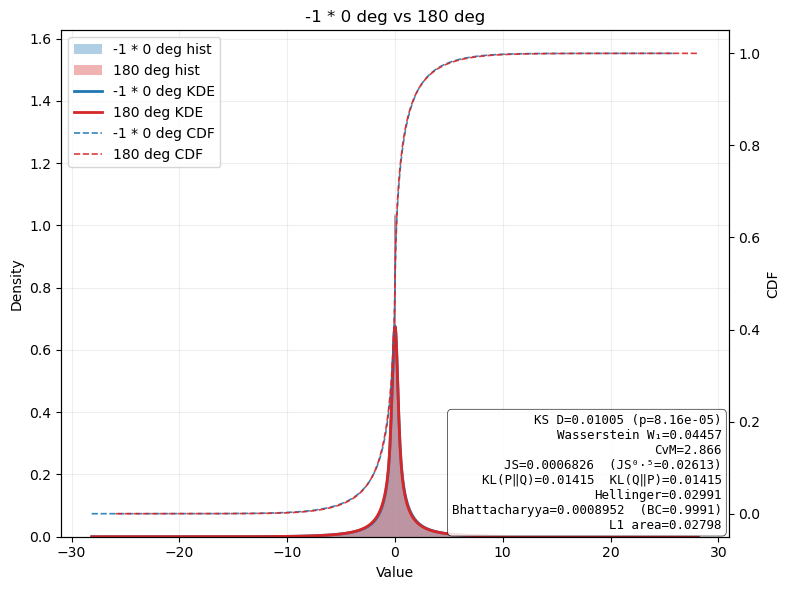

{'ks_stat': 0.010050000000000003, 'ks_p': 8.157523445175337e-05, 'wasserstein': 0.04457328637781889, 'cvm_stat': 2.8661663289531134, 'js_div': 0.0006825695080801002, 'js_dist': 0.026126031234768518, 'kl_pq': 0.01415113471836487, 'kl_qp': 0.014151134718364858, 'hellinger': 0.029913267495925402, 'bhattacharyya': 0.0008952041479750171, 'bc': 0.999105196426717, 'l1_area': 0.027979999999972006}


In [13]:
# 180 deg. vs. -1 * 0 deg.

neg_zero = -1 * filter_data_map[0]

print(f"-1 * 0 deg -- mean: {np.mean(neg_zero)}, var: {np.var(neg_zero)}")
print(f"180 deg -- mean: {np.mean(filter_data_map[2])}, var: {np.var(filter_data_map[2])}")

# x and y are 1D numpy arrays of samples
metrics = compare_and_plot(
    neg_zero, filter_data_map[2],
    bins="fd",             # 'auto'|'fd'|'doane'|'scott'|int|array
    value_range=None,      # or e.g. (-5, 5) to force same support
    show_kde=True,
    show_cdf=True,
    title="-1 * 0 deg vs 180 deg",
    labels=("-1 * 0 deg", "180 deg")
)
print(metrics)

0 deg -- mean: 1.1690276172739686e-05, var: 4.220124442651982
45 deg -- mean: 9.399801919644233e-05, var: 4.194125092832617


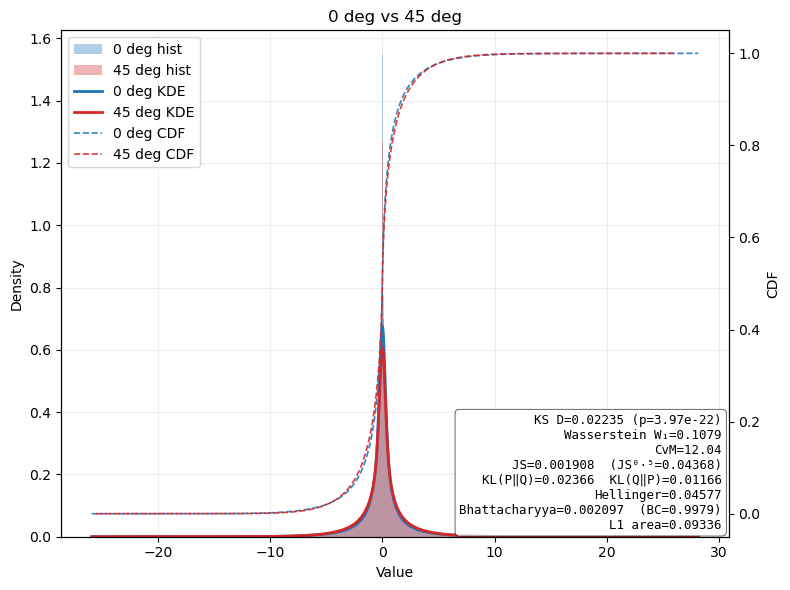

{'ks_stat': 0.022350000000000037, 'ks_p': 3.965145300817988e-22, 'wasserstein': 0.10786139295368236, 'cvm_stat': 12.043122594499437, 'js_div': 0.0019079170156484308, 'js_dist': 0.04367970942724357, 'kl_pq': 0.02366345296551329, 'kl_qp': 0.011656941481802807, 'hellinger': 0.04577065007223846, 'bhattacharyya': 0.002097149890448335, 'bc': 0.9979050475909648, 'l1_area': 0.09335999999990666}


In [14]:
# 0 deg. vs. 45 deg.

print(f"0 deg -- mean: {np.mean(filter_data_map[0])}, var: {np.var(filter_data_map[0])}")
print(f"45 deg -- mean: {np.mean(filter_data_map[1])}, var: {np.var(filter_data_map[1])}")

# x and y are 1D numpy arrays of samples
metrics = compare_and_plot(
    filter_data_map[0], filter_data_map[1],
    bins="fd",             # 'auto'|'fd'|'doane'|'scott'|int|array
    value_range=None,      # or e.g. (-5, 5) to force same support
    show_kde=True,
    show_cdf=True,
    title="0 deg vs 45 deg",
    labels=("0 deg", "45 deg")
)
print(metrics)

45 deg -- mean: 9.399801919644233e-05, var: 4.194125092832617
315 deg -- mean: -0.00010945655654208167, var: 4.204938419642695


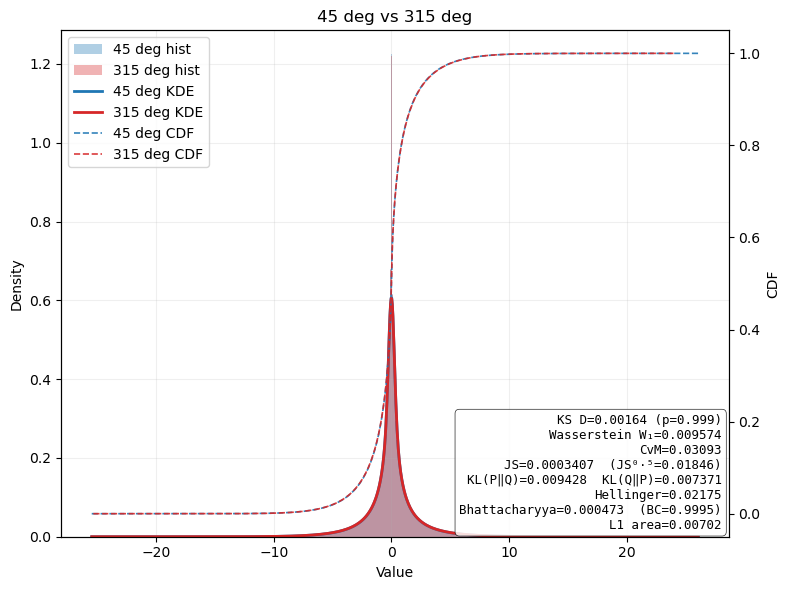

{'ks_stat': 0.0016400000000000858, 'ks_p': 0.9992658341435364, 'wasserstein': 0.009574076189741909, 'cvm_stat': 0.03092965075484244, 'js_div': 0.0003407221880788336, 'js_dist': 0.018458661600420374, 'kl_pq': 0.009427958982817373, 'kl_qp': 0.007370863673400202, 'hellinger': 0.021745551891770184, 'bhattacharyya': 0.00047298086489397194, 'bc': 0.9995271309719223, 'l1_area': 0.00701999999999298}


In [15]:
# 45 deg. vs. 315 deg.

print(f"45 deg -- mean: {np.mean(filter_data_map[1])}, var: {np.var(filter_data_map[1])}")
print(f"315 deg -- mean: {np.mean(filter_data_map[3])}, var: {np.var(filter_data_map[3])}")

# x and y are 1D numpy arrays of samples
metrics = compare_and_plot(
    filter_data_map[1], filter_data_map[3],
    bins="fd",             # 'auto'|'fd'|'doane'|'scott'|int|array
    value_range=None,      # or e.g. (-5, 5) to force same support
    show_kde=True,
    show_cdf=True,
    title="45 deg vs 315 deg",
    labels=("45 deg", "315 deg")
)
print(metrics)

45 deg -- mean: -9.399801919644233e-05, var: 4.194125092832617
315 deg -- mean: -0.00010945655654208167, var: 4.204938419642695


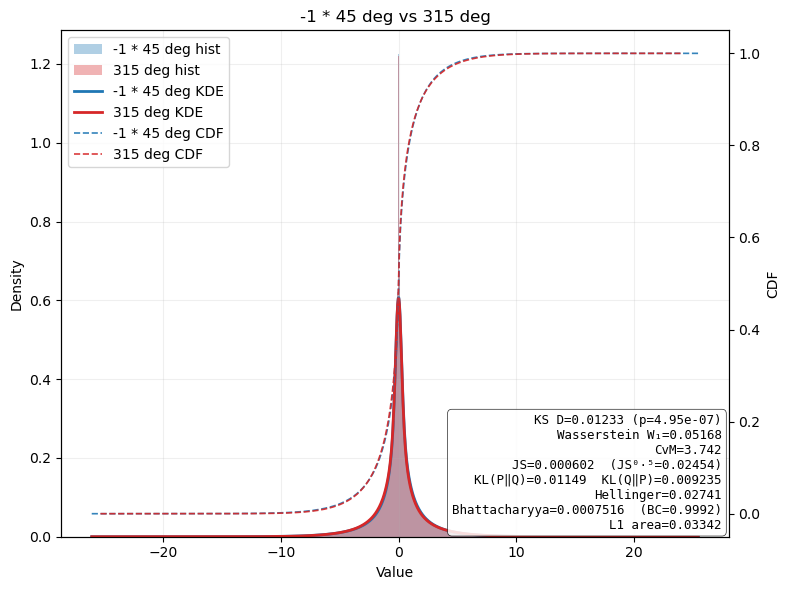

{'ks_stat': 0.012330000000000008, 'ks_p': 4.951479210813251e-07, 'wasserstein': 0.051683336775342655, 'cvm_stat': 3.742153276951285, 'js_div': 0.0006019702428442298, 'js_dist': 0.024535081879713174, 'kl_pq': 0.011486503593109751, 'kl_qp': 0.00923502715634535, 'hellinger': 0.027410292826619772, 'bhattacharyya': 0.0007516065382832533, 'bc': 0.999248675846159, 'l1_area': 0.03341999999996659}


In [16]:
# -1 * 45 deg. vs. 315 deg.

neg = -1 * filter_data_map[1]

print(f"45 deg -- mean: {np.mean(neg)}, var: {np.var(neg)}")
print(f"315 deg -- mean: {np.mean(filter_data_map[3])}, var: {np.var(filter_data_map[3])}")

# x and y are 1D numpy arrays of samples
metrics = compare_and_plot(
    neg, filter_data_map[3],
    bins="fd",             # 'auto'|'fd'|'doane'|'scott'|int|array
    value_range=None,      # or e.g. (-5, 5) to force same support
    show_kde=True,
    show_cdf=True,
    title="-1 * 45 deg vs 315 deg",
    labels=("-1 * 45 deg", "315 deg")
)
print(metrics)

# Saving Data

In [ ]:
data_output_file = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-gabor.pickle") 
size_output_file = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-gabor-size.pickle")

total_samples = np.prod(images.shape)
print("Without subsampling size:", total_samples)
print("With subsampling, per-filter:", len(filter_data_map[0]))
pd.to_pickle(filter_data_map, data_output_file)
pd.to_pickle({i : total_samples for i in range(len(filter_data_map))}, size_output_file)

Without subsampling size: 196608000
